In [12]:
import numpy as np
from datetime import datetime
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from SparseNet import *
from plink_dataloader import *
from sklearn.metrics import matthews_corrcoef
import time
import scikitplot as skplt
from torch.utils.tensorboard import SummaryWriter
import scikitplot as skplt
import matplotlib.pyplot as plt

The design and architecture of this model is greatly inspired by [GenNet](https://github.com/ArnovanHilten/GenNet), which aims at training biologicall interpretable deep learning models using sparse networks defined by biological knowledged about SNP-Gene affiliations, Gene-pathway relationships etc.
Genotype and phenotype information is stored in files "genotype.h5" and "subjects.csv". QC has been carried out beforehand for the genotype data and training-validation-test split has also been carried out beforehand and that information is embedded in "subects.csv". These files are loaded in the PyTorch datasets and loader classes.

In [2]:
genotypes = "/home/user/directory/GenNet/ready_data/full_snps/genotype.h5"
phenotypes = "/home/user/directory/GenNet/ready_data/full_snps/subjects.csv"
frq_file = pd.read_csv("/home/user/directory/phenotypes/severe_clumped.frq", sep = "\s+")

In [3]:
train_ds = load_csv(genotypes, phenotypes, 1)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

val_ds = load_csv(genotypes, phenotypes, 2)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)

test_ds = load_csv(genotypes, phenotypes, 3)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

/data/user/miniconda3/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.
/data/user/miniconda3/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:4: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  after removing the cwd from sys.path.
/data/user/miniconda3/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:7: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  import sys


The model consists of a sparse input layer that only allow connections between variants and hidden gene nodes. The sparsity of the input weight matrix is defined in the "connectivity.tsv" file defining which input nodes are connected to which hidden nodes. It is then possible to add a dense layer after the gene layer with the `hidden_features`argument in the `SparseNet`class.

In [4]:
model = SparseNet(topology_path="/home/user/Phenotype_prediction/test_connectivty.tsv",
                hidden_features=50)

The function `train_one_epoch`defines how an epoch is carried out the training loop. Parameters are adjusted using the binary cross entropy loss function weighting the positive classes by their reciprocal ratio.

In [5]:
w = torch.tensor(4.284273)
bce_loss = nn.BCEWithLogitsLoss(pos_weight=w)
learning_rate=3e-4
l1_const=5e-5
l2_const=1e-2
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_const)

def PearsonsCorrelation(output, labels):

    output = output.sigmoid().round()
    x_diff = output - output.mean()
    y_diff = labels - labels.mean()

    covar = (x_diff * y_diff).sum()
    normalization = (x_diff**2 * y_diff**2).sum().sqrt()
    
    if normalization == 0:
        return normalization
    
    else:
        return covar / normalization


def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_dl):
        
        # Every data instance is an input + label pair
        inputs, labels = data
        # Simulate missing genotypes based on MAF
        x, y = np.where(inputs.isnan() == True)
        mafs = frq_file["MAF"].iloc[y]
        counts = np.random.binomial(n=2, p=mafs)
        inputs[x, y] = torch.DoubleTensor(counts)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs.float())
        # Compute the loss and its gradients
        loss = bce_loss(outputs, labels.float())
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_ds) # loss per batch
    tb_x = epoch_index * len(train_dl) + i + 1
    tb_writer.add_scalar('Loss/train', avg_loss, tb_x)

    return avg_loss

Feeding the data to the model a single time is not enough and therefore the model must observe the data multiple times. This will present different splits of the data each time, given the `DataLoader`class' random sampling of batches. And epoch defines everytime the entire data is fed to the model. After each epoch the model is validated on the validation set using Matthew's correlation coefficient, which measures the correlation between binary variables. This metric is works very well in imbalanced datasets as it takes into account the full confusion matrix.

In [6]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('/home/user/directory/model_runs/runs/severe_asthma_trainer_{}'.format(timestamp))
epoch_number = 0
EPOCHS = 20
best_mcc = 0.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=5)

2022-01-21 11:13:59.204033: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-21 11:13:59.204073: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [7]:
train_loss = []
val_loss = []
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_mcc = 0.0
    for i, val_data in enumerate(val_dl):

        inputs, labels = val_data
        
        # Simulate missing genotypes based on MAF
        x, y = np.where(inputs.isnan() == True)
        mafs = frq_file["MAF"].iloc[y]
        counts = np.random.binomial(n=2, p=mafs)
        inputs[x, y] = torch.DoubleTensor(counts)
        
        preds = model(inputs.float()).detach().sigmoid().round()
        mcc = matthews_corrcoef(labels, preds)
        running_mcc += mcc

    avg_mcc = running_mcc / (i + 1)
    scheduler.step(avg_mcc)

    print('BCE train {} MCC valid {}'.format(avg_loss, avg_mcc))
    train_loss.append(avg_loss)
    val_loss.append(avg_mcc)

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('BCE vs. MCC',
                    { 'Training' : avg_loss, 'Validation' : avg_mcc },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_mcc > best_mcc:
        best_mcc = avg_mcc
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1
    


EPOCH 1:
BCE train 0.01757549118913475 MCC valid 0.12830396184617623
EPOCH 2:
BCE train 0.01753786376160546 MCC valid 0.04716075866119864
EPOCH 3:
BCE train 0.017497276618100705 MCC valid 0.3509303583131871
EPOCH 4:
BCE train 0.01743744147358128 MCC valid 0.3451504930732484
EPOCH 5:
BCE train 0.01735815454054119 MCC valid 0.20932798092489432
EPOCH 6:
BCE train 0.01720979149858125 MCC valid 0.33075287817407484
EPOCH 7:
BCE train 0.016970715181987502 MCC valid 0.41122215995855455
EPOCH 8:
BCE train 0.016613750978099102 MCC valid 0.3552137670174729
EPOCH 9:
BCE train 0.016312899702709948 MCC valid 0.35669001530821787
EPOCH 10:
BCE train 0.016264087734662452 MCC valid 0.3602257512695841
EPOCH 11:
BCE train 0.016214425100378634 MCC valid 0.3471307286751598
EPOCH 12:
BCE train 0.01616466623881362 MCC valid 0.3510877624842098
EPOCH 13:
BCE train 0.016126213023783326 MCC valid 0.35148233837897913
EPOCH 14:
BCE train 0.016079351128143456 MCC valid 0.3482293606021298
EPOCH 15:
BCE train 0.016048

In [10]:
test_mcc = 0.0
model_predictions = []
labels_list = []
for i, test_data in enumerate(test_dl):

    inputs, labels = test_data

    # Simulate missing genotypes based on MAF
    x, y = np.where(inputs.isnan() == True)
    mafs = frq_file["MAF"].iloc[y]
    counts = np.random.binomial(n=2, p=mafs)
    inputs[x, y] = torch.DoubleTensor(counts)

    preds = model(inputs.float()).detach().sigmoid().round()
    model_predictions.append(preds)
    labels_list.append(labels)
    
    mcc = matthews_corrcoef(labels, preds)
    test_mcc += mcc

avg_mcc_test = test_mcc / len(test_dl)
avg_mcc_test

0.3547395460786157

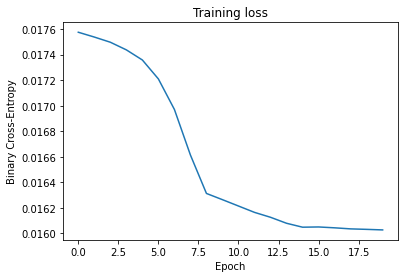

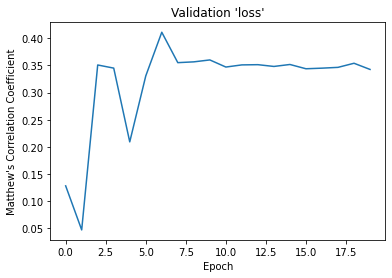

In [13]:
plt.plot(train_loss)
plt.ylabel("Binary Cross-Entropy")
plt.xlabel("Epoch")
plt.title("Training loss")
plt.show()
plt.plot(val_loss)
plt.ylabel("Matthew's Correlation Coefficient")
plt.xlabel("Epoch")
plt.title("Validation 'loss'")
plt.show()

In [15]:
torch.save(model, "/home/user/Phenotype_prediction/models/test_model_272.pth")